In [3]:
'''Prepare the notebook. Run this cell first.'''
import os, re, sys
import pandas as pd
import numpy as np
%load_ext rpy2.ipython

ImportError: No module named rpy2.ipython

In [4]:
'''Set parameters.  Run this cell before all others.'''
min_maf = 0.01 #Remove variants below this frequency. Set to 0 to keep all variants.
max_missing_sample_callrate = 0.03 #Remove samples that have greater than this percent of missing genotypes ("sample callrate").
max_missing_marker_callrate = 0.03 #Remove SNPs that have greater than this percent of missing calls ("marker callrate").
max_IBD = 0.125 #Remove samples that have identity by state greater than this coefficient of relationship (first cousins).
min_HWE_p = 0.00001 #Remove SNPs with HWE exact test p-values lower than this.
min_diffmiss_p = 0.00001 #Remove SNPs with differential missingness test p-values lower than this.

In [17]:
'''Make analysis directory and upload your data'''

import os
study_dir = '/home/brian/clink/NEIGHBOR/' #Can change this variable to suit your study.
if not os.path.isdir(study_dir): os.mkdir(study_dir)
%cd {study_dir}

#You can either upload data to the EC2 instance using the key pair you specified at instance launch,
#  for instance using scp from a system that has your data,
#  or you can fetch the data from this instance using SFTP/rsync/curl/wget/s3

#Remember that if you want to pull data from a private S3 bucket, the EC2 instance needs to assume an IAM role,
#  and that bucket must be configured for the EC2 instance's IAM role.

#In this example, I used scp from a firewalled and secured workstation to securely upload a Plink study to the EC2 instance.
#I used a command like this from my workstation:
#scp -i my_key_pair.pem my_study.* ec2-user@<IPv4_public_IP>:/gwas/my_study/
#  ..where <IPv4_public_IP> is the public IPv4 address of the EC2 instance running this notebook.

input_filestem  = 'merged_neighbor' #Set this variable to the Plink filestem of your study.
output_filestem = 'clean-' + input_filestem #Generate a new filestem for post-QC data.

/home/brian/clink/NEIGHBOR


In [18]:
'''1) Run sex check using plink.'''

#This should generate a *.sexcheck file for the study:
!plink --bfile $input_filestem --check-sex --out $input_filestem

PLINK v1.90b4.1 64-bit (30 Mar 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --check-sex
  --out merged_neighbor

64329 MB RAM detected; reserving 32164 MB for main workspace.
528478 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53

In [20]:
sexcheck_file = input_filestem + '.sexcheck'
sexprobs_file = input_filestem + '.sexprobs'

!fgrep PROBLEM $sexcheck_file > $sexprobs_file
sexproblems = !cat $sexprobs_file | wc -l
print("Number of gender discordances detected: " + str(sexproblems))

#Save the FID and IID of the individuals that failed qc, if any.
#It's okay to generate an empty file here - we'll count the lines of each fail-* file later for a sumamry.
!perl -lne 's/^\s+//; @f = split; print join "\t", (@f[0..1])' $sexprobs_file >fail-sexcheck-qc.txt

#At this point, inspect the reasons for any gender discordances.  In this case, some genders are missing in the ped file:
!head -1 $sexcheck_file #For the header.
!head -5 $sexprobs_file #Check out the first 5 discordances.

Number of gender discordances detected: ['151']
         FID          IID       PEDSEX       SNPSEX       STATUS            F
      ME8001       ME8001            0            2      PROBLEM     -0.03751
      ME8002       ME8002            0            1      PROBLEM            1
      ME8003       ME8003            0            1      PROBLEM            1
      ME8004       ME8004            0            2      PROBLEM    -0.005969
      ME8005       ME8005            0            2      PROBLEM     -0.04629


In [7]:
'''2) Marker callrate.'''
!plink --bfile $input_filestem --geno $max_missing_marker_callrate --make-bed --out $input_filestem

PLINK v1.90b4.1 64-bit (30 Mar 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --geno 0.01
  --make-bed
  --out merged_neighbor

64329 MB RAM detected; reserving 32164 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
655216 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%

In [9]:
'''3) Sample callrate.'''
!plink --bfile $input_filestem --mind $max_missing_sample_callrate --out $input_filestem

PLINK v1.90b4.1 64-bit (30 Mar 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --het
  --missing
  --out merged_neighbor

64329 MB RAM detected; reserving 32164 MB for main workspace.
547812 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52

In [10]:
'''Visualize missingness and heterozygosity from reports.'''

imiss_file = input_filestem + '.imiss'
het_file   = input_filestem + '.het'


#!head {imiss_file} #See how Plink generates some extra whitespace...
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' {imiss_file} {het_file} 
#!head {imiss_file} #Uncomment to see how this Perl one-liner cleaned up these two files for easy reading.
#Now the whitespace is cleaned up, and the original het and imiss files are backed up as *.het.bak and *.imiss.bak

imiss = pd.read_table(imiss_file, sep="\t")
het   = pd.read_table(het_file,   sep="\t")

het['meanHet'] = (het['N(NM)'] - het['O(HOM)']) / het['N(NM)'] #Compute mean heterozygosity.
imiss['logF_MISS'] = np.log10(imiss['F_MISS']) #This might generate a RuntimeWarning: "divide by zero encountered in log10" for genotypes that weren't missing in anybody.

#imiss.head()

imiss.describe()

,N_MISS,N_GENO,F_MISS,logF_MISS
count,5183.000000,5183.000000,5183.000000,5183.000000
mean,280.452827,547807.548524,0.000512,-3.781140
std,713.359390,3.974823,0.001302,0.574419
min,10.000000,547804.000000,0.000018,-4.738737
25%,31.000000,547804.000000,0.000057,-4.247260
50%,58.000000,547804.000000,0.000106,-3.975104
75%,220.000000,547812.000000,0.000402,-3.396206
max,14615.000000,547812.000000,0.026680,-1.573814


Summary of log10(missingness): [-4.739 -4.247 -3.975 -3.781 -3.396 -1.574]
Summary of mean heterozygosity: [ 0.2344  0.3188  0.3202  0.3203  0.3218  0.3605]


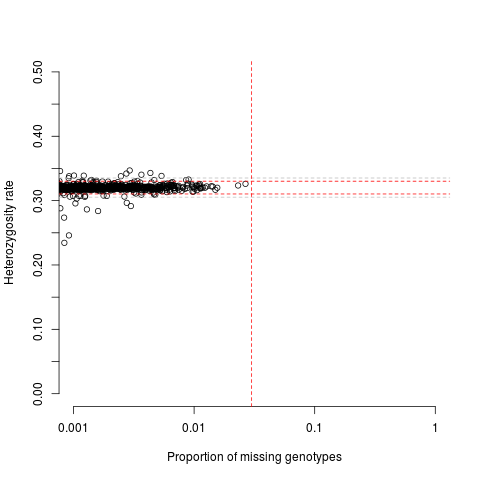

In [11]:
'''Plot missingness versus heterozygosity. Use Rmagic.'''

%Rpush imiss_file het_file
%R imiss <- read.table(imiss_file, header=T)
%R het   <- read.table(het_file,   header=T)

#Calculate the log10 of the F_MISS and the mean heterozygosity (among non-missing genotypes).
%R imiss$logF_MISS <- log10(imiss$F_MISS)
%R het$meanHet     <-  (het$N.NM. - het$O.HOM.)/het$N.NM.

%R -o summary_logF_MISS summary_logF_MISS <- summary(imiss$logF_MISS)
print("Summary of log10(missingness): " + str(summary_logF_MISS))

%R -o summary_meanHet summary_meanHet <- summary(het$meanHet)
print("Summary of mean heterozygosity: " + str(summary_meanHet))

#Plot the logF_MISS against the mean heterozygosity.
#You can modify this plotting command to focus on your range of interest.
%R plot(imiss$logF_MISS, het$meanHet, xlim=c(-3,0), ylim=c(0,0.5), pch=1, xlab="Proportion of missing genotypes", ylab="Heterozygosity rate",axes=F); axis(2,at=c(0,0.05,0.10,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5),tick=T); axis(1,at=c(-3,-2,-1,0),labels=c(0.001,0.01,0.1,1)); abline(h=mean(het$meanHet) - (2 * sd(het$meanHet)), col="RED",  lty=2); abline(h=mean(het$meanHet) - (3 * sd(het$meanHet)), col="gray", lty=2); abline(h=mean(het$meanHet) + (2 * sd(het$meanHet)), col="red",  lty=2); abline(h=mean(het$meanHet) + (3 * sd(het$meanHet)), col="gray",  lty=2); abline(v=-1.522879, col="red", lty=2)


In [12]:
'''Write file containing FID:IID pairs for individuals with outlying heterozygosity'''
%R het.filt <- het[which( het$meanHet > (mean(het$meanHet) + 3 * sd(het$meanHet)) | het$meanHet < (mean(het$meanHet) - 3 * sd(het$meanHet)) ),]
%R write.table(het.filt[,c(0,1)], file="fail-het-qc.txt", sep="\t", row.names=F, quote=F)

In [13]:
fail_het_qc_count = !cat fail-het-qc.txt | wc -l

print("Number of individuals who failed heterozygosity QC:" + str(fail_het_qc_count))

Number of individuals who failed heterozygosity QC:['103']


In [14]:
'''4) MAF'''
!plink --bfile $input_filestem --min_maf 0.01 --make-bed --out $input_filestem

PLINK v1.90b4.1 64-bit (30 Mar 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --maf 0.01
  --make-bed
  --out merged_neighbor

64329 MB RAM detected; reserving 32164 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
547812 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%

In [16]:
'''5) IBD'''
'''Generate LD-pruned variants first.'''
!plink --bfile $input_filestem --indep-pairwise 50 5 0.2 --out $input_filestem

PLINK v1.90b4.1 64-bit (30 Mar 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --indep-pairwise 50 5 0.2
  --out merged_neighbor

64329 MB RAM detected; reserving 32164 MB for main workspace.
528478 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%

In [2]:
'''If the above output pruned too few or too many SNPs, adjust the linkage R^2 value 
Increase R^2 to retain more SNPs, decrease to prune more.
The goal is to end up with about 100k SNPs for a GWAS study (>= 500k SNPs genome-wide).
Then proceed with identification of related samples.'''
prune_in_file = input_filestem + '.prune.in'
unlinked_variant_count = !cat $prune_in_file | wc -l
print "Unlinked (LD-pruned) genetic variant count: " + str(unlinked_variant_count)
!plink --bfile $input_filestem --extract $prune_in_file --genome --out $input_filestem
#That command should generate a *.genome file.

NameError: name 'output_filestem' is not defined

In [ ]:
genome_file = input_filestem + '.genome'
#Clean up the whitespace:
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' $genome_file
genome_file_line_count = !wc -l $genome_file
print "Line count in genome file (used for relationship estimation): " + str(genome_file_line_count)
!head $genome_file

In [ ]:
'''Generate a file containing FID:IID pairs of individuals to be excluded on the basis of relatedness.
Exclude the individual with greater missingness from any pair of individuals that are related more than first cousins.'''
imiss, removed = dict(), set()

with open(imiss_file) as imiss_in, open(genome_file) as genome_in, open('fail-IBD-QC.txt', 'w') as fail_IBD_out:
    #Read the missingness into a dictionary.
    header = imiss_in.readline()
    for line in imiss_in:
        fid, iid, miss_pheno, n_miss, n_geno, f_miss = line.rstrip().split("\t") #File was already whitespace-cleaned.
        imiss[(fid, iid)] = float(f_miss) #Key by FID:IID tuple, value by F_MISS (missing frequency).
        
    #Now exclude related samples. Drop whichever one has higher missingness.
    header = genome_in.readline()
    for line in genome_in:
        fid1, iid1, fid2, iid2, rt, ez, z0, z1, z2, pi_hat, phe, dst, ppc, ratio = line.rstrip().split("\t")
        if float(pi_hat) > 0.185:
            if imiss[(fid1, iid1)] >= imiss[(fid2, iid2)]: #The first sample has higher missingness.
                if (fid1, iid1) not in removed:
                    fail_IBD_out.write("\t".join([fid1, iid1]) + "\n")
                    removed.add((fid1, iid1)) #Remember that we already excluded this FID:IID pair.
            else: #The second sample has higher missingness.
                if (fid2, iid2) not in removed:
                    fail_IBD_out.write("\t".join([fid2, iid2]) + "\n")
                    removed.add((fid2, iid2))

fail_IBD_count = !cat fail-IBD-QC.txt | wc -l
print "Number of samples that failed IBD QC: " + str(fail_IBD_count)

In [ ]:
'''Now exclude the related samples from the study.'''
!plink --bfile $input_filestem --remove fail-IBD-QC.txt --make-bed --out $input_filestem

In [ ]:
'''Now that related samples have been excluded, repeat the marker callrate, sample callrate, and MAF filtering.'''


In [ ]:
'''7) Marker callrate.'''
!plink --bfile $input_filestem --geno $max_missing_marker_callrate --make-bed --out $input_filestem

In [ ]:
'''8) Sample callrate.'''
!plink --bfile $input_filestem --mind $max_missing_sample_callrate --out $input_filestem

In [ ]:
'''9) MAF'''
!plink --bfile $input_filestem --min_maf 0.01 --make-bed --out $input_filestem

In [ ]:
'''10) HWE'''
!plink --bfile $input_filestem --hwe $min_hwe_p --midp --include-nonctrl --make-bed --out $input_filestem
'''If you wish to base this test only on cases,
which requires your PED file to have accurate case/control phenotype encodings,
you can omit the --include-nonctrl option.
The mid-p modifier is recommended by Plink.'''

In [ ]:
'''11) Differential missingness (differential sample callrate).
This step relies on accurate case/control phenotype encodings in the FAM file.'''
!plink --bfile $input_filestem --test-missing --out $input_filestem
diffmiss_file = $input_filestem + '.missing'
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' {diffmiss_file} #Clean up whitespace.
diffmiss_snp_count = 0
with open('fail-diffmis-qc.txt', 'w') as fail_diffmiss, open(diffmiss_file) as diffmiss:
    header = diffmiss.readline() #Skip header line.
    for line in diffmiss:
        CHROM, SNP, F_MISS_A, F_MISS_U, P = line.rstrip().split("\t")
        if P < min_diffmis_p:
            diffmiss_snp_count += 1
            fail_difmiss.write(SNP + "\n")